```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS, LxF, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%setup_logging interpolation.log
%cuda_context_handler gpu_ctx

Registering logging to interpolation.log
Python version 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
CUDA version (9, 1, 0)
Driver version 9010
Using 'GeForce 840M' GPU
Created context handle <926408035200>


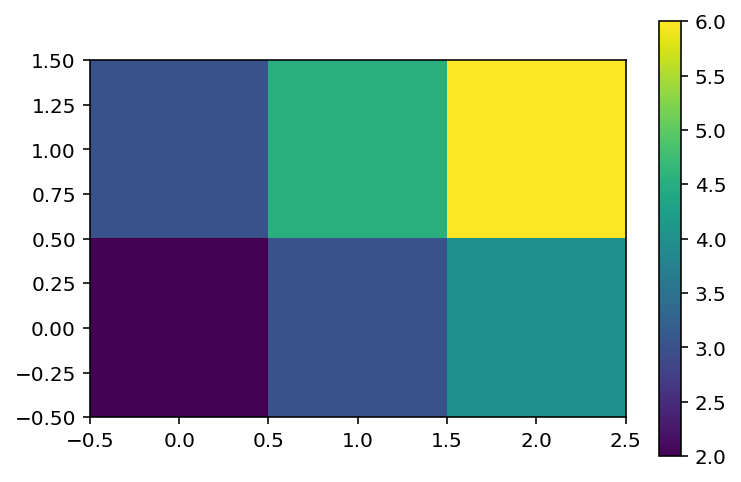

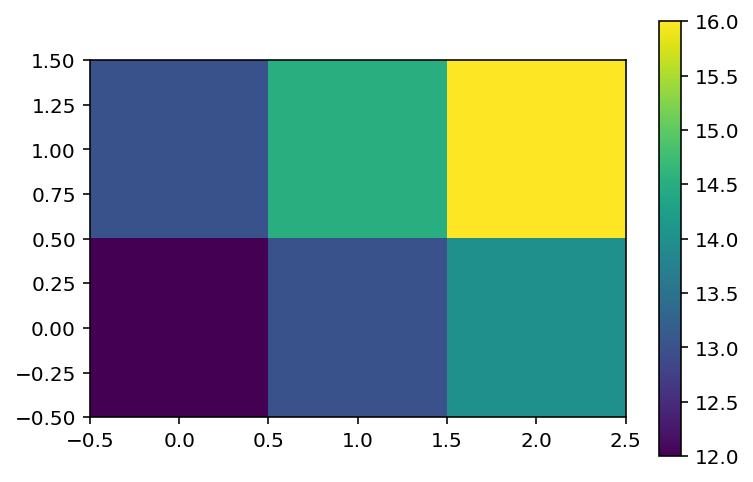

In [3]:
# Create data
tex_nx, tex_ny = 3, 2
nx, ny = 50, 50
width, height = 50, 50
dx, dy = np.float32(width/nx), np.float32(height/ny)
sx = np.linspace(1.0, 2.0, tex_nx, dtype=np.float32)
sy = np.linspace(2.0, 3.0, tex_ny, dtype=np.float32)
X = np.outer(sy, sx)
Y = 10 + X

plt.figure()
plt.imshow(X, interpolation='none', origin='lower')
plt.colorbar()

plt.figure()
plt.imshow(Y,interpolation='none', origin='lower')
plt.colorbar()

In [4]:
with Common.Timer("Compilation") as t:
    #Compile and get function
    interpolation_module = gpu_ctx.get_kernel("interpolation.cu")
    interpolation_kernel = interpolation_module.get_function("interpolationTest")
    interpolation_kernel.prepare("iifffPi")
    
    #Create stream, block, and grid
    stream = cuda.Stream()
    block=(16, 16, 1)
    grid=(int(np.ceil(nx / float(block[0]))), int(np.ceil(ny / float(block[1]))))
    
    #Get texture reference from module
    texref_curr = interpolation_module.get_texref("my_texture_current")
    cuda.matrix_to_texref(X, texref_curr, order="C")
    texref_curr.set_filter_mode(cuda.filter_mode.LINEAR)
    texref_curr.set_address_mode(0, cuda.address_mode.CLAMP)
    texref_curr.set_address_mode(1, cuda.address_mode.CLAMP)
    texref_curr.set_flags(cuda.TRSF_NORMALIZED_COORDINATES)
    
    texref_next = interpolation_module.get_texref("my_texture_next")
    cuda.matrix_to_texref(Y, texref_next, order="C")
    texref_next.set_filter_mode(cuda.filter_mode.LINEAR)
    texref_next.set_address_mode(0, cuda.address_mode.CLAMP)
    texref_next.set_address_mode(1, cuda.address_mode.CLAMP)
    texref_next.set_flags(cuda.TRSF_NORMALIZED_COORDINATES)
    
    # Allocate output data
    output_gpu = Common.CUDAArray2D(stream, nx, ny, 0, 0, np.zeros((ny, nx), dtype=np.float32))
    
print("Compilation etc took " + str(t.secs))

Compilation etc took 7.434326887130737


C:\Users\anbro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  This is separate from the ipykernel package so we can avoid doing imports until


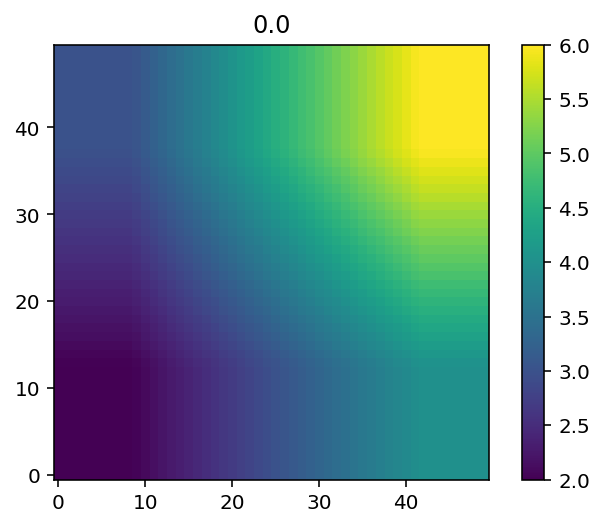

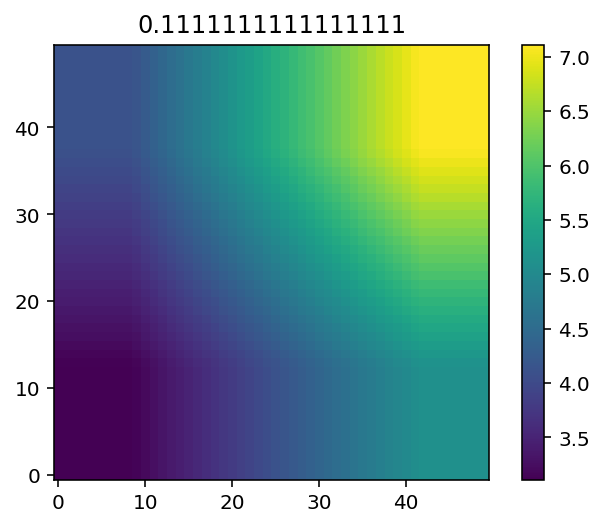

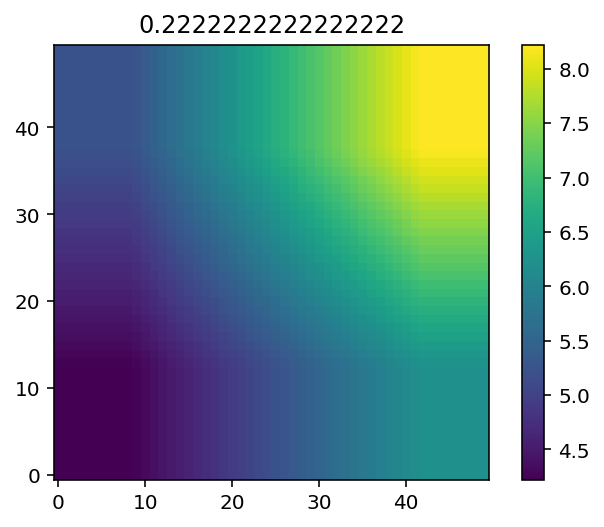

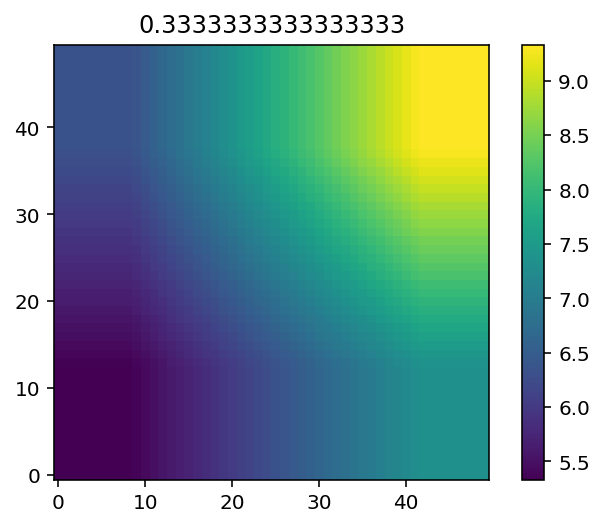

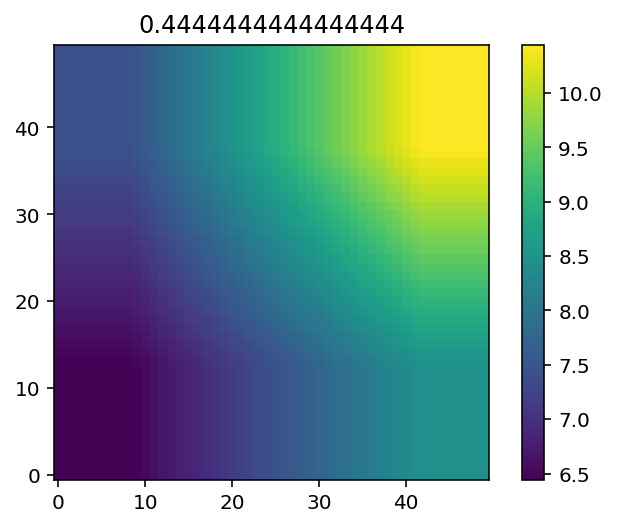

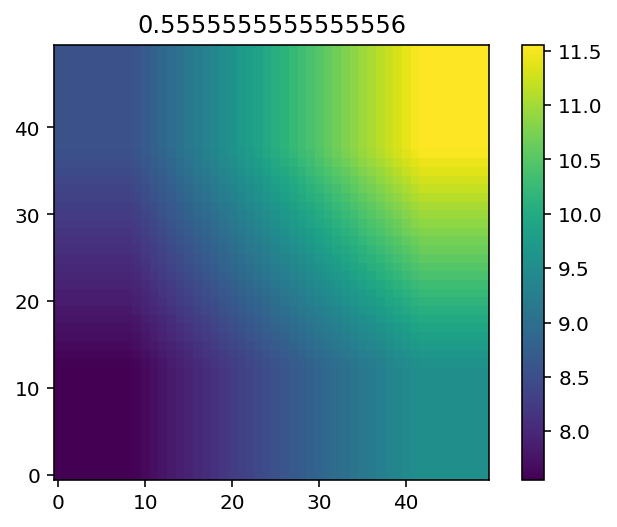

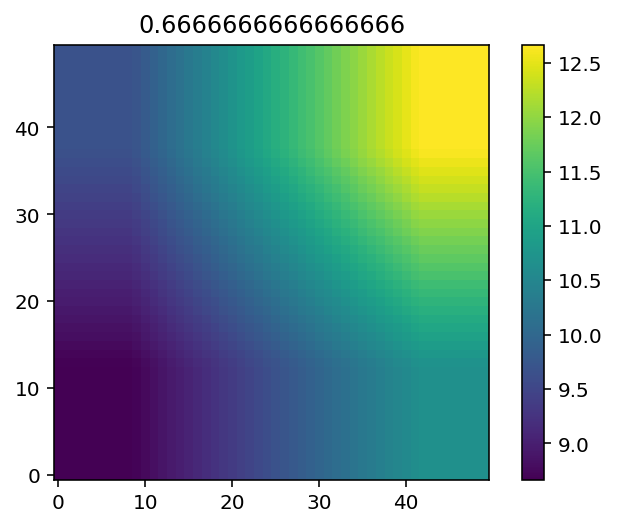

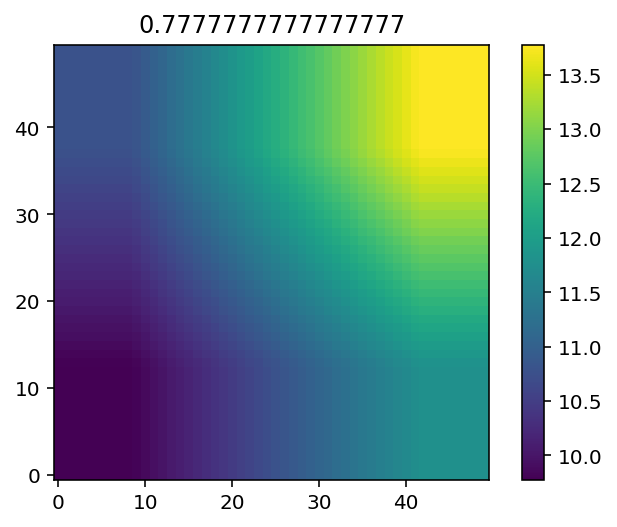

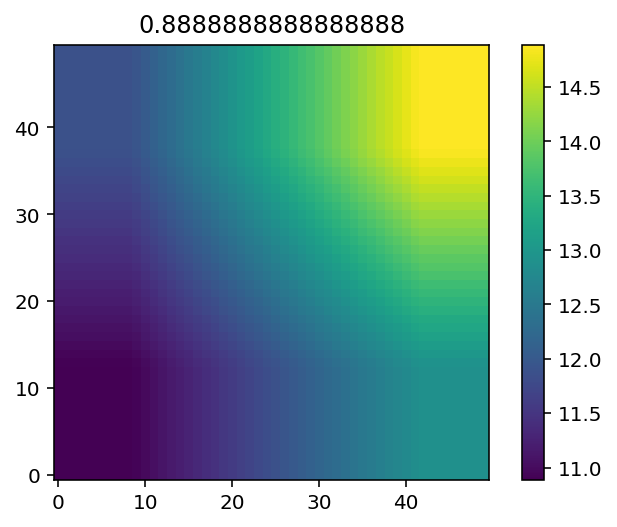

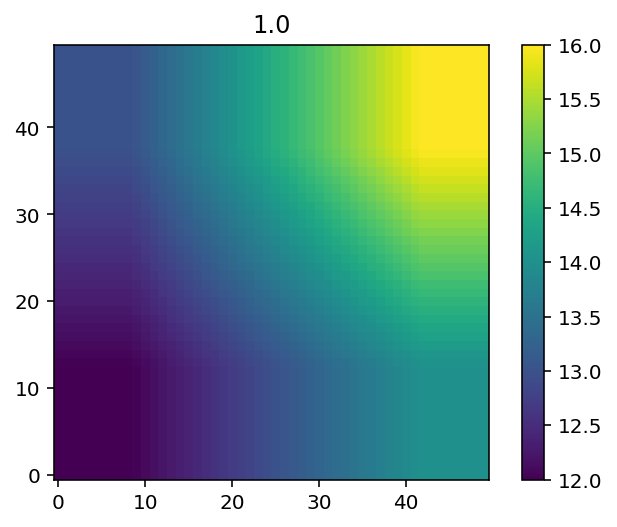

In [8]:
for t in np.linspace(0.0, 1.0, 10):
    interpolation_kernel.prepared_async_call(grid, block, stream, 
                                             nx, ny,
                                             dx, dy,
                                             t,
                                             output_gpu.data.gpudata, output_gpu.pitch)
    output = output_gpu.download(stream)
    stream.synchronize()
    
    plt.figure()
    plt.imshow(output, interpolation='none', origin='lower')
    plt.colorbar()
    plt.title(str(t))